In [67]:
from numpy import * 

# 数据导入
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float, curLine))
        dataMat.append(fltLine)
    return mat(dataMat)

# 计算距离
def distEclud(vecA, vecB):
    return sqrt(sum(power(vecA-vecB, 2)))

# 随机质心
def randCent(dataSet, k):
    n = shape(dataSet)[1]
    centroids = mat(zeros((k, n)))
    for j in range(n):
        minJ = min(dataSet[:, j])
        rangeJ = float(max(dataSet[:, j]) - minJ)
        centroids[:, j] =  minJ + rangeJ * random.rand(k,1)
    return centroids


dataMat = loadDataSet('testSet2.txt')
randCent(dataMat, 2)
dataMat.shape

(60, 2)

In [68]:
"""
    k均值据类算法
    算法会创建k个质心，然后将每个点分配到最近的质心，在重新计算质心。该过程重复执行，知道质心不再改变
"""
def KMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    m = shape(dataSet)[0] 
    clusterAssment = mat(zeros((m, 2)))
#     print(clusterAssment)
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):
            minDist = inf; minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j, :], dataSet[i, :])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i, 0] != minIndex:
                clusterChanged = True
            clusterAssment[i, :] = minIndex, minDist**2
#         print(clusterAssment)
        for cent in range(k):
#             print(nonzero(clusterAssment[:,0].A == cent)[0])
#             print((clusterAssment[:, 0].A==cent), type(clusterAssment[:,0].A==cent))
            ptsInClust = dataSet[nonzero(clusterAssment[:, 0].A==cent)[0]]
            centroids[cent, :] = mean(ptsInClust, axis=0)
    return centroids, clusterAssment


centroids, clusterAssment = KMeans(dataMat, 3)
centroids

matrix([[ 2.93386365,  3.12782785],
        [-0.45965615, -2.7782156 ],
        [-2.94737575,  3.3263781 ]])

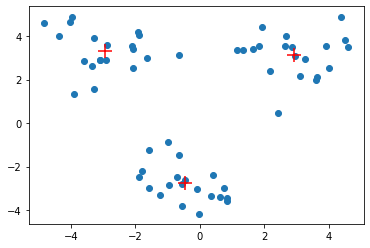

In [69]:
import matplotlib.pyplot as plt

# dataMat.A
plt.scatter(dataMat.A[:, 0], dataMat.A[:, 1])
plt.scatter(centroids.A[:, 0], centroids.A[:, 1], marker='+', c='red', s=200)

## 避免聚类收敛到局部最小
* 合并最近的质心
* 合并两个使得SSE增幅最小的质心

In [70]:
mean(dataMat, axis=0).tolist()[0]

[-0.15772275000000002, 1.2253301166666664]

In [76]:
"""
    二分K 均值算法
    将所有点作为一个簇，然后将该簇一分为二。之后选择其中一个簇（可以最大程度降低SSE（Sum of Square Error:误差平方和））
    ，上述基于SSE不断重复，直到得到指定数目的簇
"""
def biKmeans(dataSet, k, distMeans=distEclud):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))
    centroid0 = mean(dataSet, axis=0).tolist()[0]
#     print(centroid0)
    centList = [centroid0]
#     print(centList)
    for j in range(m):
        clusterAssment[j, 1] = distMeans(mat(centroid0), dataSet[j, :]) ** 2
#     print(clusterAssment)
    while (len(centList) < k):
        lowestSSE = inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0], :]
            centroidMat, splitClustAss = KMeans(ptsInCurrCluster, 2, distMeans)
            sseSplit = sum(splitClustAss[:,1])
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0], 1])
            print("sseSplit and notSplit", sseSplit, sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
#         print(bestClustAss)
        bestClustAss[nonzero(bestClustAss[:, 0].A==1)[0], 0] = len(centList)
        bestClustAss[nonzero(bestClustAss[:, 0].A==0)[0], 0] = bestCentToSplit
        print('len(centList): %s, bestCentToSplit:%s' % (len(centList), bestCentToSplit))
        print("The bestCentToSplit is :", bestCentToSplit)
        print("The len os bestClustAss is :", len(bestClustAss))
        print("The bestNewCents:", bestNewCents)
        print("The bestNewCents[:, 0] :", bestNewCents[0, :])
        print("centList: ", centList)
        print("")
        
        centList[bestCentToSplit] = bestNewCents[0,:]
        print("centList: ", centList)
#         print(clusterAssment)
        centList.append(bestNewCents[1, :])
        clusterAssment[nonzero(clusterAssment[:,0].A==bestCentToSplit)[0], :] = bestClustAss
    return centList, clusterAssment
        

centroids, clusterAssment = biKmeans(dataMat, 3)
print("centroids: ", centroids)
print("clusterAssment: ", clusterAssment)

sseSplit and notSplit 541.2976292649145 0.0
len(centList): 1, bestCentToSplit:0
The bestCentToSplit is : 0
The len os bestClustAss is : 60
The bestNewCents: [[-1.70351595  0.27408125]
 [ 2.93386365  3.12782785]]
The bestNewCents[:, 0] : [[-1.70351595  0.27408125]]
centList:  [[-0.15772275000000002, 1.2253301166666664]]

centList:  [matrix([[-1.70351595,  0.27408125]])]
sseSplit and notSplit 67.2202000797829 39.52929868209309
sseSplit and notSplit 23.79175073044931 501.7683305828214
len(centList): 2, bestCentToSplit:0
The bestCentToSplit is : 0
The len os bestClustAss is : 40
The bestNewCents: [[-2.94737575  3.3263781 ]
 [-0.45965615 -2.7782156 ]]
The bestNewCents[:, 0] : [[-2.94737575  3.3263781 ]]
centList:  [matrix([[-1.70351595,  0.27408125]]), matrix([[2.93386365, 3.12782785]])]

centList:  [matrix([[-2.94737575,  3.3263781 ]]), matrix([[2.93386365, 3.12782785]])]
centroids:  [matrix([[-2.94737575,  3.3263781 ]]), matrix([[2.93386365, 3.12782785]]), matrix([[-0.45965615, -2.7782156

[matrix([[-2.94737575,  3.3263781 ]]), matrix([[2.93386365, 3.12782785]]), matrix([[-0.45965615, -2.7782156 ]])]
[-2.94737575, 2.93386365, -0.45965614999999993] [3.3263781000000003, 3.12782785, -2.7782156000000002]


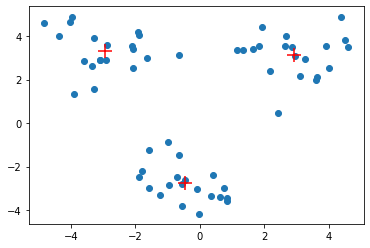

In [94]:
import matplotlib.pyplot as plt


# centroids
x = []
y = []
for i in centroids:
    x.append(i.A[0][0])
    y.append(i.A[0][1])
print(centroids)
print(x, y)
# dataMat.A
plt.scatter(dataMat.A[:, 0], dataMat.A[:, 1])
plt.scatter(x, y, marker='+', c='red', s=200)
